### predict the chances for a goal in the next minute

In [1]:
cd ..

/Users/nellekesmits/Documents/projects/notebook.goalpredictor


In [2]:
# to do:
# read smoteENN functioning

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsbombpy import sb
import notebooks.utils as utils
import SoccermaticsForPython.FCPython as sfp_fcp
import SoccermaticsForPython as sfp
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


In [6]:
events_all_matches['minute'].plot(kind='hist', bins=100)
plt.title('distributies van activiteit per minuuut')
plt.show()

NameError: name 'events_all_matches' is not defined

In [ ]:
# sns.histplot(data=events_all_matches, x="minute",bins=30)

#### import dataset

In [7]:
df = pd.read_csv('data/train_dataset.csv', index_col=0)
df.set_index('uniekid', inplace=True)

In [ ]:
df.head(1)

#### create train and testset

In [9]:
# algemene train en testset
X = df.drop('goal', axis=1)
y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [10]:
y_test.value_counts(normalize=True)

0.0    0.982977
1.0    0.017023
Name: goal, dtype: float64

In [11]:
# verschillende balaning technieken testen met verschillende strategy's

In [12]:
# strategies = np.linspace(0,1,10)    #1 = 50/50 distribution between 0 and 1 class, 0.5 = 66 (0) and 33 (1) distribution
# strategy = 0.25
# strategy = 0.5
strategy = 0.75

In [13]:
rus = RandomUnderSampler(random_state=0,sampling_strategy=strategy)    # remove 0 class
ros = RandomOverSampler(random_state =0, sampling_strategy=strategy)   # add copies 1 class
smote = SMOTE(random_state =0,sampling_strategy=strategy)              # add synthetic 1 class
sme = SMOTEENN(random_state=0, sampling_strategy=strategy)             # https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smoteENN, y_train_smoteENN = sme.fit_resample(X_train, y_train)

In [14]:
y_train_rus.value_counts(normalize=True)  

0.0    0.570881
1.0    0.429119
Name: goal, dtype: float64

In [15]:
y_train_ros.value_counts(normalize=True)  

0.0    0.571461
1.0    0.428539
Name: goal, dtype: float64

In [16]:
y_train_smote.value_counts(normalize=True)

0.0    0.571461
1.0    0.428539
Name: goal, dtype: float64

In [17]:
y_train_smoteENN.value_counts(normalize=True)  

1.0    0.508453
0.0    0.491547
Name: goal, dtype: float64

In [18]:
X_train_tot = [X_train, X_train_rus, X_train_ros, X_train_smote,X_train_smoteENN]
y_train_tot = [y_train, y_train_rus, y_train_ros, y_train_smote, y_train_smoteENN]
sampling_technique = ['nothing', 'undersampling' ,'oversampling' , 'smote' , 'smoteENN']

#### create model

In [19]:
models = []

models
models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("RandomForest",RandomForestClassifier()))

In [ ]:
results = []
techniques = []
names = []
train = []

for name, model in models:
    for technique, x, y in zip(sampling_technique, X_train_tot, y_train_tot):
        mod = make_pipeline(StandardScaler(), model)
        result = cross_val_score(mod, x, y,  cv=3)
        mod.fit(x, y)            
        names.append(name)
        results.append(result)
        techniques.append(technique)
        print(f'volgende ronde met een bepaalde sampling technique: {technique}:')
        print(name)
        print(result)
        print('with the following confusion matrix: ')
        plot_confusion_matrix(mod, X_test, y_test)  
        plt.show()

In [ ]:
for i in range(len(names)):
    print(names[i],results[i].mean())

/Users/nellekesmits/Documents/projects/notebook.goalpredictor/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


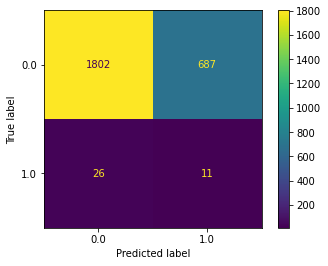

scores:  [0.58490566 0.37735849 0.45283019 0.56603774 0.56603774]


In [161]:
#bagging technique

balbag = BalancedBaggingClassifier(base_estimator = forest, n_estimators = 500, bootstrap = False,  bootstrap_features= True,
                                  sampling_strategy = strategy, replacement = False, n_jobs = -1, random_state = 5)
model_full_sample = balbag.fit(X_train, y_train)

/Users/nellekesmits/Documents/projects/notebook.goalpredictor/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Forest -- Accuracy:0.795 / Precision:0.018 / Recall:0.243 / F1:0.034 / ROC:0.523 


/Users/nellekesmits/Documents/projects/notebook.goalpredictor/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/nellekesmits/Documents/projects/notebook.goalpredictor/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


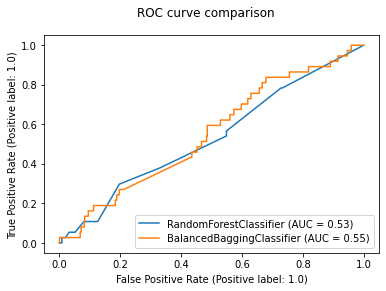

In [162]:
evaluate_model('Forest', model_full_sample, X_test, y_test)

rfc_single_disp = plot_roc_curve(model1, X_test, y_test)
rfc_disp = plot_roc_curve(model_full_sample, X_test, y_test, ax=rfc_single_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")
plt.show()

/Users/nellekesmits/Documents/projects/notebook.goalpredictor/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


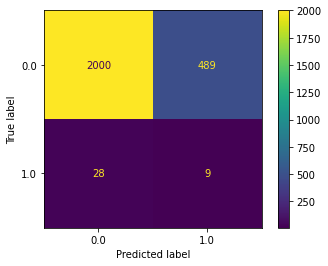

In [163]:
plot_confusion_matrix(model_full_sample, X_test, y_test)  
plt.show()

In [ ]:
# one class classifier

In [ ]:
# mod.fit(X_train_rus, y_train_rus)
# plot_confusion_matrix(mod, X_test, y_test)  
# plt.show()

# scores = cross_val_score(mod, X_train_rus, y_train_rus, cv=5)
# print('scores: ',scores)

# mod.fit(X_train_ros, y_train_ros)
# plot_confusion_matrix(mod, X_test, y_test)  
# plt.show()

# scores = cross_val_score(mod, X_train_ros, y_train_ros, cv=5)
# print('scores: ',scores)

# mod.fit(X_train_smote, y_train_smote)
# plot_confusion_matrix(mod, X_test, y_test)  
# plt.show()

# scores = cross_val_score(mod, X_train_smote, y_train_smote, cv=5)
# print('scores: ',scores)

# forest = RandomForestClassifier(random_state=5, criterion = 'entropy', n_jobs = -1)
# model1 = forest.fit(X_train,y_train)
# plot_confusion_matrix(model1, X_test, y_test)  
# plt.show()

# scores = cross_val_score(model1, X_train, y_train, cv=5)
# print('scores: ',scores)